In [1]:
import os
import numpy as np
from PIL import Image

class DataPreprocessing:
    def __init__(self, image_size, save_dir):
        self.image_size = image_size
        self.save_dir = save_dir

    def preprocess_data(self, balanced_dataset_dir):
        # Check if preprocessed data already exists
        if self.check_preprocessed_data_exists():
            print("Preprocessed data already exists. Skipping preprocessing.")
            return self.load_preprocessed_data()
        else:
            print("Preprocessed data does not exist. Preprocessing...")

        # Create lists to store image data and corresponding labels
        image_data = []
        labels = []

        # List all class directories in the balanced dataset
        class_directories = [d for d in os.listdir(balanced_dataset_dir) if os.path.isdir(os.path.join(balanced_dataset_dir, d))]

        # Assign numerical labels to each class
        class_to_label = {class_name: i for i, class_name in enumerate(class_directories)}

        for class_dir in class_directories:
            class_path = os.path.join(balanced_dataset_dir, class_dir)
            image_files = os.listdir(class_path)
            class_label = class_to_label[class_dir]

            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)

                # Resizing and scaling the image using PIL
                with Image.open(image_path) as img:
                    img = img.resize(self.image_size) 
                    img = img.convert("L")  
                    img_array = np.array(img) / 255.0 

                image_data.append(img_array)
                labels.append(class_label)

        # Convert the lists to NumPy arrays
        image_data = np.array(image_data)
        labels = np.array(labels)

        # Save the preprocessed data
        self.save_preprocessed_data(image_data, labels)

        return image_data, labels

    def save_preprocessed_data(self, image_data, labels):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        np.save(os.path.join(self.save_dir, "image_data.npy"), image_data)
        np.save(os.path.join(self.save_dir, "labels.npy"), labels)

    def check_preprocessed_data_exists(self):
        return os.path.exists(os.path.join(self.save_dir, "image_data.npy")) and os.path.exists(os.path.join(self.save_dir, "labels.npy"))

    def load_preprocessed_data(self):
        image_data = np.load(os.path.join(self.save_dir, "image_data.npy"))
        labels = np.load(os.path.join(self.save_dir, "labels.npy"))
        return image_data, labels

# Example usage:
image_size = (32,32)
save_dir = r"F:\End_To_End_project\Kidney_Disease_Classification_DL\data\preprocessed_data_for_Lenet_model"
balanced_dataset_dir = r"F:\End_To_End_project\Kidney_Disease_Classification_DL\data\balanced_dataset"

data_preprocessor = DataPreprocessing(image_size, save_dir)
image_data, labels = data_preprocessor.preprocess_data(balanced_dataset_dir)


Preprocessed data already exists. Skipping preprocessing.


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(data_dir, test_size=0.3, val_size=0.5, random_state=42):
    # Loading the data from .npy files
    image_data = np.load(os.path.join(data_dir, "image_data.npy"))
    labels = np.load(os.path.join(data_dir, "labels.npy"))

    # Spliting the data into training, testing, and validation sets
    X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=test_size, random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)

    return X_train, y_train, X_test, y_test, X_val, y_val

data_dir = r"F:\End_To_End_project\Kidney_Disease_Classification_DL\data\preprocessed_data_for_Lenet_model"
X_train, y_train, X_test, y_test, X_val, y_val = split_data(data_dir, test_size=0.3, val_size=0.5)


In [3]:
print(f"Shape of x_train data :{X_train.shape}")
print(f"Shape of y_train data :{y_train.shape}")
print(f"Shape of x_val data :{X_val.shape}")
print(f"Shape of y_val data :{y_val.shape}")
print(f"Shape of X_test data :{X_test.shape}")
print(f"Shape of y_test data :{y_test.shape}")

Shape of x_train data :(3855, 32, 32)
Shape of y_train data :(3855,)
Shape of x_val data :(827, 32, 32)
Shape of y_val data :(827,)
Shape of X_test data :(826, 32, 32)
Shape of y_test data :(826,)


### Applying One-Hot Encoding

In [4]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)


In [5]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.models import Sequential
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Let's Build the Model Architecture

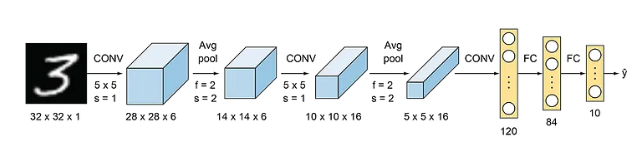

In [6]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5), padding ='valid',activation='tanh', input_shape = (32,32,1)))
model.add(AveragePooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(16, kernel_size=(5,5), padding='valid',activation='tanh' ))
model.add(AveragePooling2D(pool_size=(2,2),strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(4, activation='softmax'))


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

#### Let's Define the checkpoint and earlyStopping

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_lenet_model.h5',
                             monitor = 'val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              patience=5,
                              verbose=1)

callbacks = [checkpoint, earlystopping]

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val),callbacks=callbacks)


Epoch 1/50
119/121 [============================>.] - ETA: 0s - loss: 1.0449 - accuracy: 0.5488
Epoch 1: val_accuracy improved from -inf to 0.68077, saving model to best_lenet_model.h5
121/121 [==============================] - 10s 46ms/step - loss: 1.0408 - accuracy: 0.5499 - val_loss: 0.8002 - val_accuracy: 0.6808


f:\End_To_End_project\Kidney_Disease_Classification_DL\kidney\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
119/121 [============================>.] - ETA: 0s - loss: 0.7376 - accuracy: 0.7046
Epoch 2: val_accuracy improved from 0.68077 to 0.72068, saving model to best_lenet_model.h5
121/121 [==============================] - 4s 36ms/step - loss: 0.7367 - accuracy: 0.7056 - val_loss: 0.7256 - val_accuracy: 0.7207
Epoch 3/50
120/121 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.7620
Epoch 3: val_accuracy improved from 0.72068 to 0.78114, saving model to best_lenet_model.h5
121/121 [==============================] - 4s 37ms/step - loss: 0.6032 - accuracy: 0.7621 - val_loss: 0.5624 - val_accuracy: 0.7811
Epoch 4/50
121/121 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.8060
Epoch 4: val_accuracy improved from 0.78114 to 0.81378, saving model to best_lenet_model.h5
121/121 [==============================] - 4s 34ms/step - loss: 0.5022 - accuracy: 0.8060 - val_loss: 0.4749 - val_accuracy: 0.8138
Epoch 5/50
121/121 [====================

### Let's Plot the Model Loss and Model Accuracy

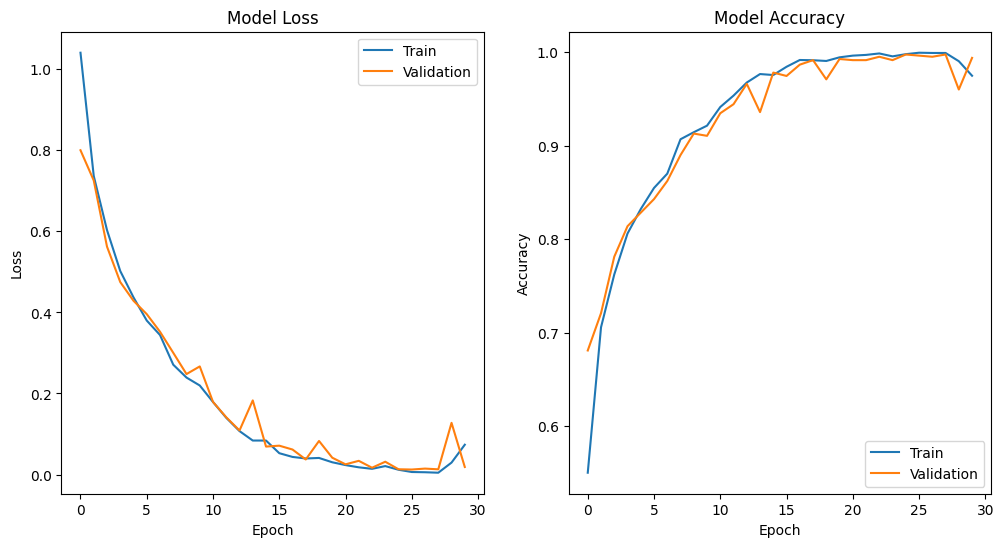

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()


26/26 [==============================] - 1s 11ms/step


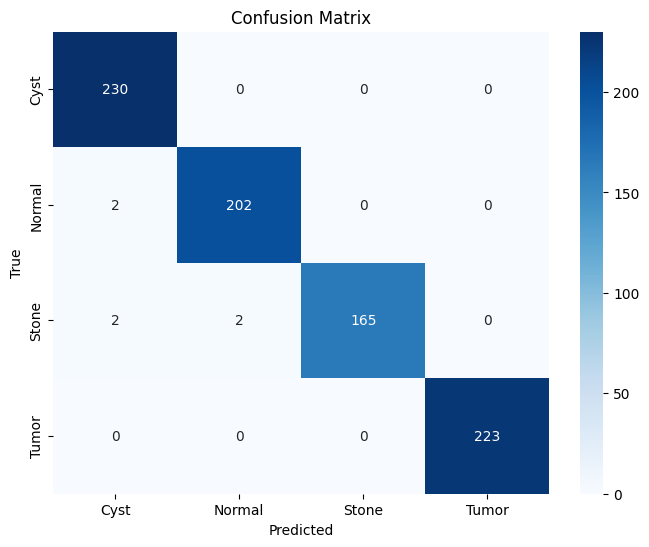

              precision    recall  f1-score   support

        Cyst       0.98      1.00      0.99       230
      Normal       0.99      0.99      0.99       204
       Stone       1.00      0.98      0.99       169
       Tumor       1.00      1.00      1.00       223

    accuracy                           0.99       826
   macro avg       0.99      0.99      0.99       826
weighted avg       0.99      0.99      0.99       826



In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load your model (replace 'your_model.h5' with the actual model file)
from keras.models import load_model

path = r"F:\End_To_End_project\Kidney_Disease_Classification_DL\research\best_lenet_model.h5"
model = load_model(path)

y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integer format
y_true = np.argmax(y_test, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Generate a classification report
class_labels = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}
report = classification_report(y_true, y_pred_classes, target_names=[class_labels[i] for i in range(len(class_labels))])



def plot_confusion_matrix(cm, class_labels):
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm, [class_labels[i] for i in range(len(class_labels))])

# Print the classification report
print(report)


In [24]:
input_image = np.expand_dims(X_test[0], axis=0)

# Perform the prediction
y_pred = model.predict(input_image)


1/1 [==============================] - 1s 622ms/step


In [26]:
predicted_class = np.argmax(y_pred)
predicted_class


2

In [27]:
class_labels = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

predicted_class_index = np.argmax(y_pred)
predicted_class = class_labels[predicted_class_index]

In [28]:
predicted_class

'Stone'

In [29]:
y_test[0]

array([0., 0., 1., 0.], dtype=float32)